# Text Processing with NLTK
In this example we will explore some of the functionality in [Natural Language Toolkit (NLTK)](http://www.nltk.org/). NLTK is one of the most popular Python based tools to get started with NLP.

There is also an entire [NLTK book](https://www.nltk.org/book/) with fantastic examples to help you explore the tools in much greater detail.

In [1]:
import nltk
import IPython.core.display as disp

# Run the following line the first time you run this script
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sebastian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Perform Part-of-Speech (POS) Tagging
The first step is ironically not entire a rule-based approach. We will tokenize the sentence into its individual words and then perform part-of-speech tagging, which typically requires a model trained from data -- this makes sense, because figuring the out the part-of-speech of a word has more exceptions than rules, especially in a language as weird as English!

In [2]:
def tag_sentence(sentence):
    tokenized = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokenized)
    return tagged

input_sentence = "Go over to the kitchen and find a big red apple."
print(input_sentence)

tagged_sentence = tag_sentence(input_sentence)
print(tagged_sentence)

Go over to the kitchen and find a big red apple.
[('Go', 'VB'), ('over', 'IN'), ('to', 'TO'), ('the', 'DT'), ('kitchen', 'NN'), ('and', 'CC'), ('find', 'VB'), ('a', 'DT'), ('big', 'JJ'), ('red', 'JJ'), ('apple', 'NN'), ('.', '.')]


## Create a Grammar and Parse the Sentence
Once we have a tokenized and tagged sentence, we can create a *grammar* of rules to help us *chunk* the sentence. In the example below, we create a simple grammar to extract Noun Phrases (NP) and Verb Phrases (VP) from a tagged sentence using a regular expression parser in NLTK.

To explain the grammar a little more, we have used the following (imperfect and limited) definitions:

* **Noun Phrase:** Any number of determinants -> Any number of adjectives -> Any number of nouns
* **Verb Phrase:** A verb -> any number of (prepositions, the word "to", adverbs, or particles) -> A noun phrase

Recall that the \* character in regular expressions refers to zero or more matches, and the . character refers to any character (since there are many verb tags depending on conjugration)

To understand what all these tags like `DT`, `JJ`, `NN`, etc. mean, refer to the [Penn Treebank list of tags](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

(S
  (VP Go/VB over/IN to/TO (NP the/DT kitchen/NN))
  and/CC
  (VP find/VB (NP a/DT big/JJ red/JJ apple/NN))
  ./.)


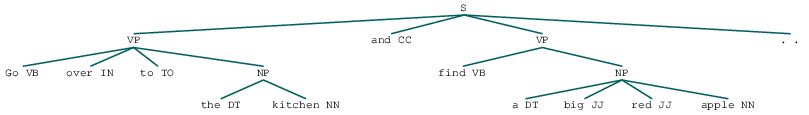

In [3]:
grammar = """
          NP: {<DT>* <JJ>* <NN>*}           # Noun phrase
          VP: {<VB.*> <IN|TO|RB|RP>* <NP>}  # Verb phrase
          """
chunk_parser = nltk.RegexpParser(grammar)

input_sentence = "Go over to the kitchen and find a big red apple."
tagged_sentence = tag_sentence(input_sentence)
tree = chunk_parser.parse(tagged_sentence)

print(tree)
disp.display(tree)

## Extract information from the parse tree
Once we have a parse tree with verb phrases and noun phrases, in theory this structure can make it easier to analyze complex sentences. For example, we could possibly infer the subject/object of a sentence, or resolve relations and references between named entities in a sentence. There is a whole field of problems with such sentences such as *Named Entity Recognition (NER)* and *Coreference Resolution*.

In our example below, we can now break down sentences into multiple verb phrases. For each verb phrase, we can extract information such as the verb and first noun and possibly infer that the human is requesting a robot to take a specific action.

In [4]:
def extract_information(tree):
    """ 
    Extracts information (actions and targets) from a tagged and chunked sentence
    """

    actions = []
    targets = []

    # Loop through all the trees
    for elem in tree:
        action = None
        target = None

        # Get the label of the subtree or token
        if isinstance(elem, nltk.tree.Tree):
            label = elem.label()
        elif isinstance(elem, tuple):
            label = elem[1]

        # Once a verb phrase is found, pick out the first verb
        if label == "VP":
            leaves = elem.leaves()
            for (word, label) in leaves:
                if "VB" in label and action is None:
                    action = word
                    break
            
            # Now find the first noun phrase and pick out the first noun
            for st in elem.subtrees():
                if st.label() == "NP":
                    leaves = st.leaves()
                    for (word, label) in leaves:
                        if "NN" in label and target is None:
                            target = word
                            break
        
        # If an action and/or target is found, append it to the list
        if action is not None or target is not None:
            actions.append(action)
            targets.append(target)

    return actions, targets


(actions, targets) = extract_information(tree)
print("Input sentence:  {}".format(input_sentence))
print("Actions:         {}".format(actions))
print("Targets:         {}".format(targets))

Input sentence:  Go over to the kitchen and find a big red apple.
Actions:         ['Go', 'find']
Targets:         ['kitchen', 'apple']


## Test on Multiple Sentences
Again, we should test our NLP pipeline on various types of sentences to see how robust our system is to the types of commands we may expect humans to give.

We as developers have no way to limit the space of possible sentences a rule-based system can see out in the wild, which makes them brittle in the real world. This is one of many reasons that machine learning approaches are dominating NLP today. However, many complex systems can benefit from a combination of rule-based and statistical methods to combine their respective advantages.

Input sentence:  Go over to the kitchen and find a big red apple.


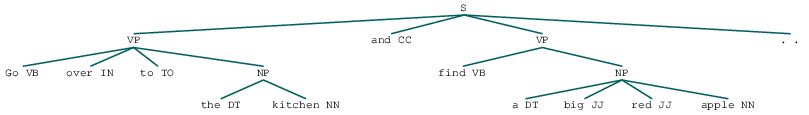

Actions:         ['Go', 'find']
Targets:         ['kitchen', 'apple']

Input sentence:  Open the refrigerator and grab a cold water bottle.


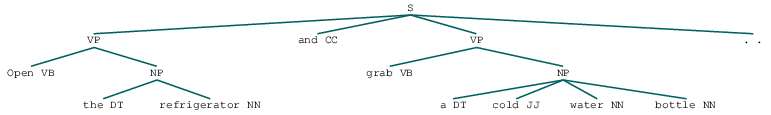

Actions:         ['Open', 'grab']
Targets:         ['refrigerator', 'water']

Input sentence:  Proceed to the garage and empty out the trash.


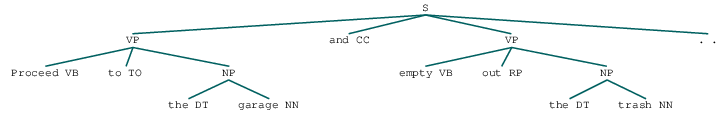

Actions:         ['Proceed', 'empty']
Targets:         ['garage', 'trash']



In [5]:
input_doc = "Go over to the kitchen and find a big red apple. " \
            "Open the refrigerator and grab a cold water bottle. " \
            "Proceed to the garage and empty out the trash."
sentences = nltk.sent_tokenize(input_doc)

for sent in sentences:
    tagged_sentence = tag_sentence(sent)
    tree = chunk_parser.parse(tagged_sentence)
    (actions, targets) = extract_information(tree)
    print("Input sentence:  {}".format(sent))
    disp.display(tree)
    print("Actions:         {}".format(actions))
    print("Targets:         {}".format(targets))
    print("")